NOTES

- 1 ns unit for time
- Conventions:
  - [qubit, resonator 1]
  - Qubit, pump: blue
  - Resonator 1, coupling 1: green

In [42]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import plots
import os
import shutil
import time
from datetime import datetime
from glob import glob
from copy import copy
from supports_1q_2c import *
from qutip import *
from scipy.special import erf
from scipy.signal import argrelextrema

options = Options()

In [104]:
Nq = 3   # number of levels in qubit
N1 = 10  # number of levels in resonator 1

wq = 6.5*2*pi    # qubit frequency
w1 = 4*2*pi    # resonator 1 frequency
Omega = 0.6*2*pi  # amplitude of sideband transitions
wsb = 1/4*(3*wq - w1 - sqrt((wq + w1)**2 - 4*Omega**2))  # pump drive frequency

kq = 50e-6*2*pi  # photon emission frequency of qubit (qubit decay rate)
k1 = 10e-6*2*pi  # photon emission freqency of resonator 1 (resonator 1 decay rate)

g1 = 0.2*2*pi  # drive frequency resonator 1, coupling between qubit and resonator 1

Ec = 0.16*2*pi  # Anharmonicity (charging energy)

In [91]:
t0 = 0         # start Gaussian pulse Omega
t1 = t0 + 0   # end Gaussian pulse Omega
t2 = t1 + 0   # start square pulse at resonator 1
t3 = t2 + 50  # end square pulse at resonator 1
t4 = t3 + 0   # start square pulse at resonator 2
t5 = t4 + 0  # end square pulse at resonator 2
t6 = t5 + 10   # t0
tg = 10        # Gaussian rise and fall time of square pulse

N_repeat = 1  # number of times to repeat cycle
Np = 200*int(t6)     # number of discrete time steps per cycle for which to store the output
smooth = False  # square pulses rise and fall with Gaussian
Q = 3  # number of std's in Gaussian curves, rises and falls

In [92]:
# Qubit operators
b = tensor(destroy(Nq), qeye(N1))
nq = b.dag()*b
sx = tensor(sigmax(), qeye(N1)) # x-projection of qubit level
sy = tensor(sigmay(), qeye(N1)) # y-projection of qubit level
sz = tensor(sigmaz(), qeye(N1)) # z-projection of qubit level

# Cavity operators
a1 = tensor(qeye(Nq), destroy(N1))
n1 = a1.dag()*a1

# Jaynes-Cummings Hamiltonian (not the measurement hamiltonian)
Hjc = 1/2*wq*nq + w1*n1 - Ec/2*b.dag()*b.dag()*b*b

# Coupling Hamiltonians (only red sideband transitions)
H1 = g1*(a1*b.dag() + b*a1.dag())

# Hamiltonian arguments
H_args = {"t0" : t0, "t1" : t1, "t2" : t2, "t3" : t3, 
          "t4" : t4, "t5" : t5, "t6" : t6, "tg" : tg,
          "g1" : g1, "Q"  : Q, "smooth" : smooth, 
          "wsb" : wsb, "Omega" : Omega, "Np" : Np, "N_repeat" : N_repeat}

# Sideband transitions
Hsb = Omega*(b + b.dag())

In [93]:
# Collapse operators, losses
cq = sqrt(kq)*b   # qubit
c1 = sqrt(k1)*a1  # resonator 1
c_ops = []

# Expectation operators
e_ops = [nq, n1]

In [94]:
H = [Hjc, [Hsb, sideband], [H1, square1]]  # complete Hamiltonian
psi0 = tensor(psi_pi(Nq), basis(N1,0))  # initial state

# Select these options for bdf method
options.method = 'bdf'
options.rtol = 1e-30

# Select these options for adams method
# options.nsteps = 1000000
# options.rtol = 1e-9
# options.max_step = 0.1

options.store_states=True

Np_per_batch = Np/40  # number of time points per batch

In [95]:
batches = create_batches(0, N_repeat*t6, N_repeat*Np, Np_per_batch)

# Remove existing progress folder
for folder in glob("/home/student/thesis/prog_*"):
    shutil.rmtree(folder)

# Make new progress folder
now = datetime.now().strftime("%y_%m_%d_%H_%M_%S")
folder = "/home/student/thesis/prog_" + now
os.makedirs(folder)

# Calculate!
for num, tlist in enumerate(batches):
    print(num+1, "/", len(batches), ":", int(np.round(100*(num+1)/len(batches))), "%")
    result = mesolve(H, psi0, tlist, c_ops, e_ops=e_ops, args=H_args, options=options)
    saveprog(result, num, folder)
    psi0 = copy(result.states[-1])
    del result
print("Evolution completed")
combine_batches(folder, quants=['times', 'expect'], return_data=False)
print("Batches combined")

1 / 40 : 2 %
2 / 40 : 5 %
3 / 40 : 8 %
4 / 40 : 10 %
5 / 40 : 12 %
6 / 40 : 15 %
7 / 40 : 18 %
8 / 40 : 20 %
9 / 40 : 22 %
10 / 40 : 25 %
11 / 40 : 28 %
12 / 40 : 30 %
13 / 40 : 32 %
14 / 40 : 35 %
15 / 40 : 38 %
16 / 40 : 40 %
17 / 40 : 42 %
18 / 40 : 45 %
19 / 40 : 48 %
20 / 40 : 50 %
21 / 40 : 52 %
22 / 40 : 55 %
23 / 40 : 58 %
24 / 40 : 60 %
25 / 40 : 62 %
26 / 40 : 65 %
27 / 40 : 68 %
28 / 40 : 70 %
29 / 40 : 72 %
30 / 40 : 75 %
31 / 40 : 78 %
32 / 40 : 80 %
33 / 40 : 82 %
34 / 40 : 85 %
35 / 40 : 88 %
36 / 40 : 90 %
37 / 40 : 92 %
38 / 40 : 95 %
39 / 40 : 98 %
40 / 40 : 100 %
Evolution completed
Batches combined


In [96]:
tfile = open(folder + "/times.pkl", 'rb')
tdata = pickle.load(tfile)
times = tdata['data']
tfile.close()

# sfile = open(folder + "/states.pkl", 'rb')
# sdata = pickle.load(sfile)
# states = sdata['data']
# sfile.close()

efile = open(folder + "/expect.pkl", 'rb')
edata = pickle.load(efile)
expect = edata['data']
efile.close()

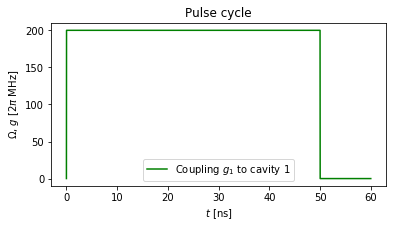

In [97]:
sqr1_pulse = g1/(2*pi)*1000*square1(times, H_args)
plt.figure(figsize=[6,3])
plt.plot(times, sqr1_pulse, color='g', label='Coupling $g_1$ to cavity 1')
# plt.xlim([0, 10])
# plt.ylim([0,12.5])
plt.xlabel("$t$ [ns]")
plt.ylabel("$\\Omega$, $g$ [$2\\pi$ MHz]")
plt.title("Pulse cycle")
plt.legend()

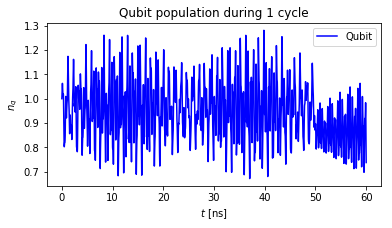

In [98]:
obj = 0    # 0 = qubit, 1 = cavity 1, 2 = cavity 2
ind = int(300/2)  # index of tlist

plt.figure(figsize=[6,3])
if obj == 0:
    plt.plot(times, expect[obj], color='b', label='Qubit')
elif obj == 1:
    plt.plot(times, expect[obj], color='g', label='Cavity 1')

# VARIABLE PLOT SETTINGS    
# plt.xlim([0, 10])
# plt.ylim([0, 0.52])

plt.xlabel("$t$ [ns]")
if obj > 0:
    plt.ylabel("$n_{}$".format(obj))
    plt.title("Cavity {} population during 1 cycle".format(obj))
else:
    plt.ylabel("$n_q$")
    plt.title("Qubit population during 1 cycle")
plt.legend()

# cont = plots.wigner(states, obj=obj, ind=ind)
# plots.dmat_hinton(states, obj=obj, ind=ind)

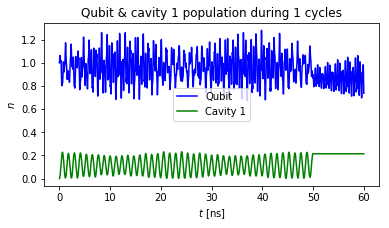

In [99]:
plt.figure(figsize=[6,3])
plt.plot(times, expect[0], color='b', label='Qubit')
plt.plot(times, expect[1], color='g', label='Cavity 1')
# plt.xlim([0, 10])
# plt.ylim([0, 2.8])
plt.xlabel("$t$ [ns]")
# plt.ylabel("$n_{}$".format(obj))
plt.ylabel("$n$")
plt.legend()
plt.title("Qubit & cavity 1 population during {} cycles".format(N_repeat))
plt.show()